## Imports

In [10]:
import os

import random
import numpy as np
import keras

import tensorflow as tf# import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

import keras.utils as image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

2022-12-23 20:44:15.553372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 20:44:15.646241: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-23 20:44:15.646256: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-23 20:44:16.349916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

## Dataset

In [11]:
root = '../datasets/PetImages'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
print(categories)

['../datasets/PetImages/Cat', '../datasets/PetImages/Dog']


In [12]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [13]:
data = []

for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
            in os.walk(category) for f in filenames 
            if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images[:2500]:
        try:
            img, x = get_image(img_path)
            data.append({'x':np.array(x[0]), 'y':c})
        except:
            print("Error: {}".format(img_path))
        
# count the number of classes
num_classes = len(categories)

In [14]:
len(data)

5000

In [15]:
random.shuffle(data)

In [16]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [17]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

In [18]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(750, 2)


In [19]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 5000 images from 2 categories
train / validation / test split: 3500, 750, 750
training data shape:  (3500, 224, 224, 3)
training labels shape:  (3500, 2)


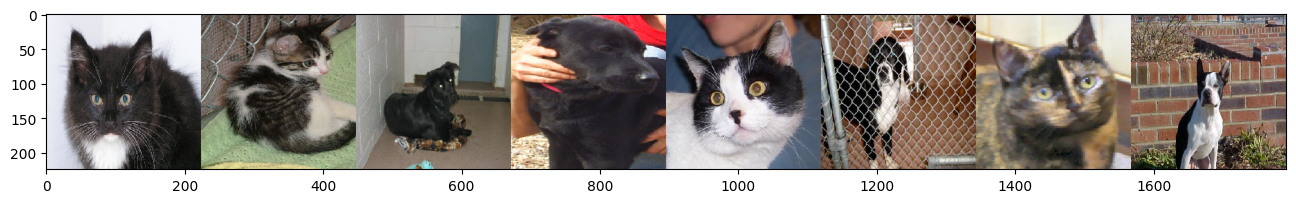

In [20]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

In [21]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                   

2022-12-23 20:44:25.992335: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-23 20:44:25.992354: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-23 20:44:25.992372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (keven-b4dluck): /proc/driver/nvidia/version does not exist
2022-12-23 20:44:25.992536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=4,
                    validation_data=(x_val, y_val))

Epoch 1/4


2022-12-23 20:44:26.158021: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2107392000 exceeds 10% of free system memory.


28/28 [==============================] - 61s 2s/step - loss: 0.6912 - accuracy: 0.5257 - val_loss: 0.6668 - val_accuracy: 0.6000
Epoch 2/4
28/28 [==============================] - 64s 2s/step - loss: 0.6487 - accuracy: 0.6117 - val_loss: 0.6298 - val_accuracy: 0.6427
Epoch 3/4
28/28 [==============================] - 64s 2s/step - loss: 0.6103 - accuracy: 0.6569 - val_loss: 0.5713 - val_accuracy: 0.7080
Epoch 4/4
28/28 [==============================] - 64s 2s/step - loss: 0.5590 - accuracy: 0.7080 - val_loss: 0.5238 - val_accuracy: 0.7547


In [23]:
history.history

{'loss': [0.6912062764167786,
  0.648727536201477,
  0.6103331446647644,
  0.5590443015098572],
 'accuracy': [0.5257142782211304,
  0.6117143034934998,
  0.6568571329116821,
  0.7080000042915344],
 'val_loss': [0.6667829751968384,
  0.6297572255134583,
  0.571254551410675,
  0.5238367915153503],
 'val_accuracy': [0.6000000238418579,
  0.6426666378974915,
  0.7080000042915344,
  0.7546666860580444]}

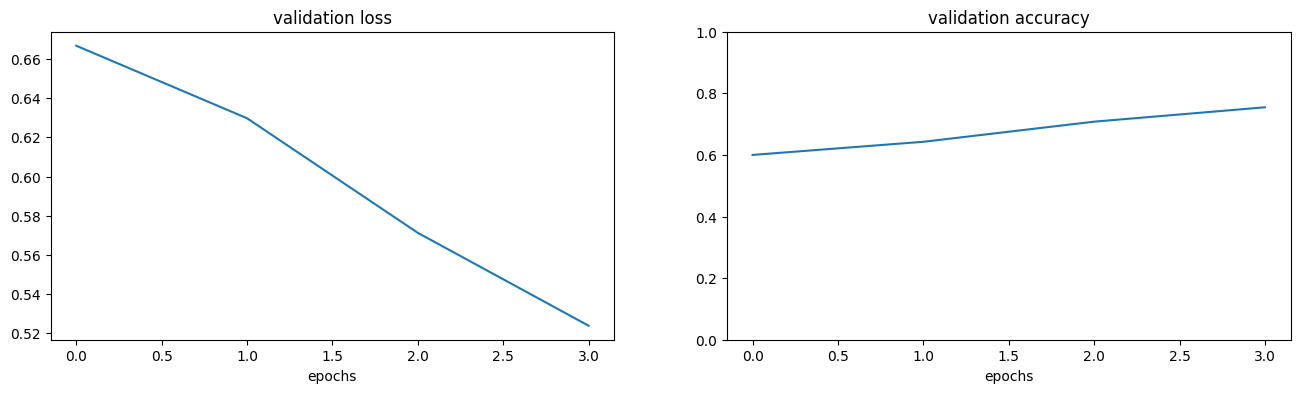

In [24]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121)
ax.plot(history.history['val_loss'])
ax.set_title('validation loss')
ax.set_xlabel('epochs')

ax2 = fig.add_subplot(122)
ax2.plot(history.history['val_accuracy'])
ax2.set_title('validation accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylim(0, 1)

plt.show();

In [25]:
loss, accuracy = model.evaluate(x_test, y_test)

24/24 [==============================] - 3s 106ms/step - loss: 0.5707 - accuracy: 0.7000


In [26]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [28]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [29]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=4, 
                         validation_data=(x_val, y_val))

Epoch 1/4


2022-12-23 20:48:44.418036: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2107392000 exceeds 10% of free system memory.
2022-12-23 20:48:45.605802: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1644167168 exceeds 10% of free system memory.
2022-12-23 20:48:45.938886: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1644167168 exceeds 10% of free system memory.


 1/28 [>.............................] - ETA: 4:32 - loss: 0.8537 - accuracy: 0.4922

2022-12-23 20:48:55.198824: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1644167168 exceeds 10% of free system memory.


28/28 [==============================] - 288s 10s/step - loss: 0.6712 - accuracy: 0.6446 - val_loss: 0.4392 - val_accuracy: 0.8480
Epoch 2/4
28/28 [==============================] - 278s 10s/step - loss: 0.3936 - accuracy: 0.8466 - val_loss: 0.3421 - val_accuracy: 0.8813
Epoch 3/4
28/28 [==============================] - 278s 10s/step - loss: 0.3383 - accuracy: 0.8683 - val_loss: 0.3048 - val_accuracy: 0.8893
Epoch 4/4
28/28 [==============================] - 280s 10s/step - loss: 0.3043 - accuracy: 0.8849 - val_loss: 0.2721 - val_accuracy: 0.9107


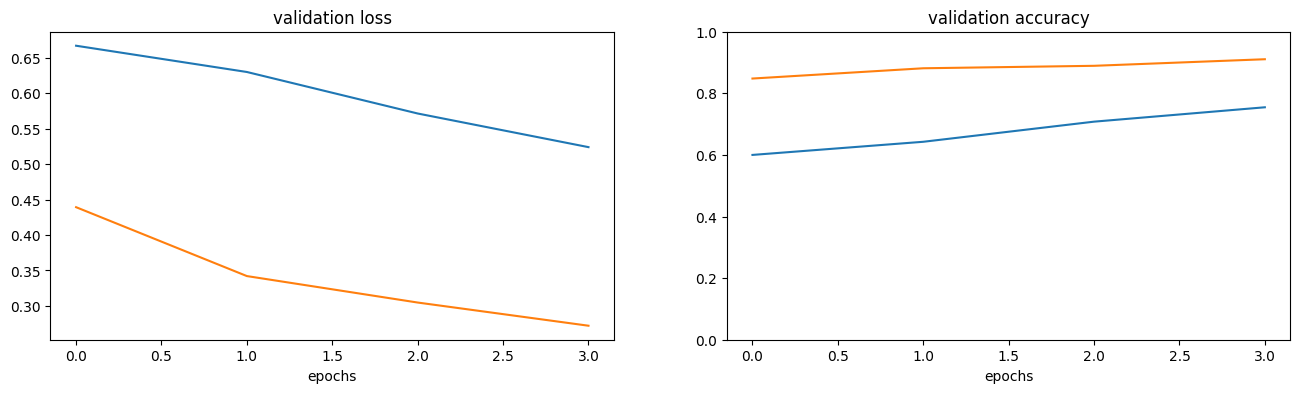

In [30]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [31]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.27797913551330566
Test accuracy: 0.8973333239555359


In [44]:
img, x = get_image('../datasets/PetImages/Dog/10001.jpg')
probabilities = model_new.predict([x])

1/1 [==============================] - 0s 130ms/step


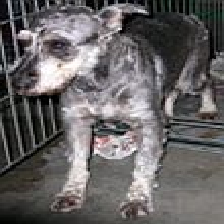

In [45]:
img

In [46]:
probabilities

array([[1.0472198e-15, 1.0000000e+00]], dtype=float32)